Цель: Проанализировать данные о заработной плате сотрудников из файла ds_salaries.csv и построить модели машинного обучения для прогнозирования заработной платы.  

Задачи:  

1. Первичный анализ данных:  
— Импортировать данные из файла ds_salaries.csv.  
— Очистить данные от дубликатов и пропущенных значений.   
— Исследовать типы данных, описательную статистику и корреляции между признаками.  
— Визуализировать данные с помощью Matplotlib и Seaborn.  



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from pathlib import Path

In [2]:
dataset_filename = './ds_salaries.csv'
df = pd.read_csv(dataset_filename)
df.shape

(3755, 11)

In [3]:
# Датафрейм содержит 1171 полных дубликатов. Их нужно удалить
df.duplicated().value_counts()

False    2584
True     1171
Name: count, dtype: int64

In [4]:
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(2584, 11)

In [5]:
# Имеется один код валюты, похоже, что с очень низким курсом 
df.loc[df['salary_currency'] =='CLP'].query('salary_currency == "CLP"')


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
2499,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L


In [6]:
df.drop(axis=0, index=df.loc[df['salary_currency'] =='CLP'].index, inplace=True) #.query('salary_currency == "CLP"')
df.reset_index(drop=True, inplace=True)
#df = df.loc[df['salary_currency'] !='CLP']
df.query('salary_currency == "CLP"')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size


In [7]:
# Сгруппируем основную информацию о датасете и выгрузим в excel.
# import io
info_filename = f'./{Path(dataset_filename).stem}_info.xlsx'
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
columns = s.splitlines()[3].split()
lines =   [line.split() for line in s.splitlines()[5:-2]]
lines = [[' '.join(row[1:-3]), row[-3], row[-2], row[-1]   ] for row in lines]
# lines
# columns[1:]
# df_info = pd.DataFrame(lines,columns=columns[1:])
# df_info['nu'] = df.nunique().values
# df.nunique().n
# df_info.join(df.nunique(), on='Column')
# df.nunique().to_frame(name='Columns').reset_index()
# pd.concat([pd.DataFrame(lines,columns=columns[1:]), df.nunique()], axis=1, ignore_index=True)# .set_index(['#']).reset_index()
df_info = pd.merge(
    pd.DataFrame(lines, columns=columns[1:])
    , df.nunique().to_frame(name='Nu'), 
    left_on='Column', 
    right_index=True)# .set_index(['#']).reset_index()
df_vc = pd.DataFrame([[col, sorted(df[col].value_counts().to_dict().items(), key=lambda x: x[0])] for col in df.columns if len(df[col].value_counts()) < 21], columns=['Column', 'vc'])
df_info = pd.merge(df_info, df_vc, how='left', on='Column')
df_info = pd.merge(df_info, df.describe().T, how='left', left_on='Column', right_index=True)
if not Path(info_filename).exists():
    df_info.to_excel(info_filename)
df_info

,Column,Non-Null,Count,Dtype,Nu,vc,count,mean,std,min,25%,50%,75%,max
0,work_year,2583,non-null,int64,4,"[(2020, 75), (2021, 227), (2022, 1125), (2023,...",2583.0,2022.301587,0.748886,2020.0,2022.0,2022.0,2023.0,2023.0
1,experience_level,2583,non-null,object,4,"[(EN, 270), (EX, 96), (MI, 663), (SE, 1554)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,employment_type,2583,non-null,object,4,"[(CT, 10), (FL, 10), (FT, 2546), (PT, 17)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,job_title,2583,non-null,object,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,salary,2583,non-null,int64,814,NaN,2583.0,198677.478126,547771.168580,6000.0,90000.0,134500.0,182500.0,11000000.0
5,salary_currency,2583,non-null,object,19,"[(AUD, 9), (BRL, 6), (CAD, 25), (CHF, 4), (CZK...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,salary_in_usd,2583,non-null,int64,1034,NaN,2583.0,133445.428571,67124.680816,5132.0,85000.0,130000.0,175000.0,450000.0
7,employee_residence,2583,non-null,object,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,remote_ratio,2583,non-null,int64,3,"[(0, 1186), (50, 187), (100, 1210)]",2583.0,50.464576,48.163172,0.0,0.0,50.0,100.0,100.0
9,company_location,2583,non-null,object,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Датасет не содержим явных и неявных пропусков
# Выделим в датасете числовые и категориальные признаки
target_name = 'salary_in_usd'
num_features = ['salary']
cat_features = ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
ohe_features = []
map_coder_features = {}

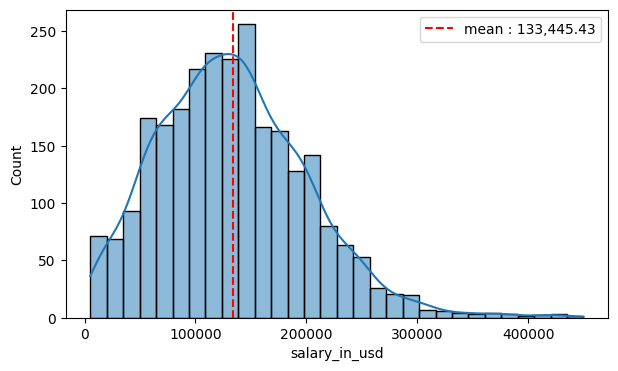

In [9]:
# Отобразим график распределения целевой переменной
target_feature_mean = df[target_name].mean()
plt.figure(figsize=(7,4))
g1 = sns.histplot(x=df[target_name], bins=30, kde=True);
g1.axvline(target_feature_mean, color='red', ls='--', label=f"mean : {target_feature_mean:,.2f}")
plt.legend();
# Наблюдаем распределение целевой переменной похожее на нормальное с правым "хвостом"
# Пока не понято являются ли большие значения выбросами

In [10]:
df.loc[df[target_name]>350_000]
# Высокие значения зпл наблюдаются у работников с высокой квалификацией. На данном этапе, предположим, что это не выбросы.

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
392,2023,EX,FT,Director of Data Science,353200,USD,353200,US,0,US,M
427,2023,SE,FT,AI Scientist,1500000,ILS,423834,IL,0,IL,L
512,2023,SE,FT,Data Architect,376080,USD,376080,US,100,US,M
785,2023,SE,FT,Data Scientist,370000,USD,370000,US,0,US,M
874,2022,SE,FT,Machine Learning Software Engineer,375000,USD,375000,US,100,US,M
890,2023,SE,FT,Data Analyst,385000,USD,385000,US,0,US,M
901,2023,SE,FT,Research Scientist,370000,USD,370000,US,0,US,M
1352,2022,MI,FT,Data Analyst,350000,GBP,430967,GB,0,GB,M
1564,2022,SE,FT,Data Science Tech Lead,375000,USD,375000,US,50,US,L
2294,2022,SE,FT,Data Analytics Lead,405000,USD,405000,US,100,US,L


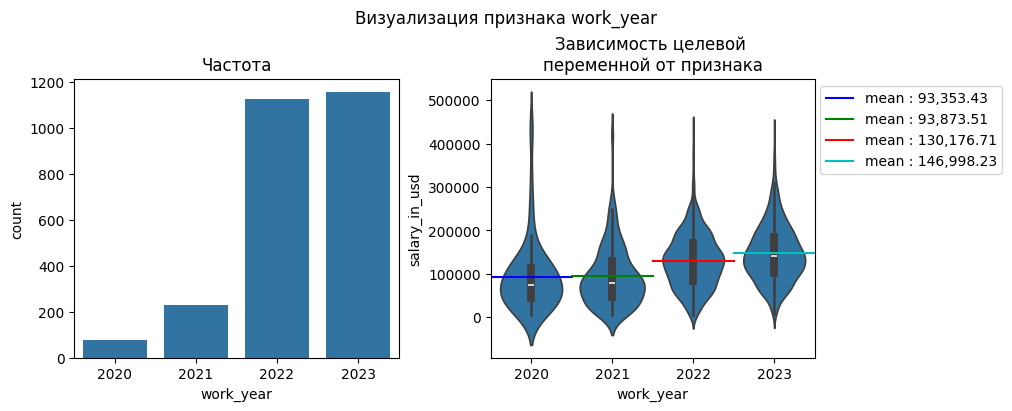

In [11]:
# Отобразим уровень зарплаты в USD в зависимости от года выплаты
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
feature_name = 'work_year'
#plt.figure(figsize=(5, 4))
uniq_features_value = sorted(df[feature_name].unique())
color_dict = dict(zip(uniq_features_value, colors))
fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g2 = sns.countplot(ax=axs[0], x=df[feature_name])
g2 = sns.violinplot(ax=axs[1], y=df[target_name], x=df[feature_name])
for i, el in enumerate(uniq_features_value):
    interval = 1/len(uniq_features_value)
    target_feature_mean = df.loc[df[feature_name] == el][target_name].mean()
    g2.axhline(target_feature_mean, color=color_dict[el] , xmin=i * interval, xmax=(i + 1) * interval, label=f"mean : {target_feature_mean:,.2f}")#, ls='--', label=f"mean : {target_feature_mean:,.2f}");
# plt.subplots_adjust(wspace=0.3, hspace=1)
plt.legend(bbox_to_anchor=(1.6, 1))
axs[0].set_title('Частота')
axs[1].set_title('Зависимость целевой \nпеременной от признака');
# Наблюдаем, зависимость роста медианного значения целевой переменной при увеличении года.
# Не будем специально преобразовывать переменную к числовому виду, т.к. значения имеют естественную порядковую связь и при
# стандартизации/масштабировании будут преобразованы к одному масштабу


# fig.suptitle('Зависимость целевой переменной от OverallQual')
# sns.scatterplot(ax=axs[0], data=df, x='OverallQual', y='SalePrice')
# sns.boxplot(ax=axs[1], data=df, x='OverallQual', y='SalePrice')

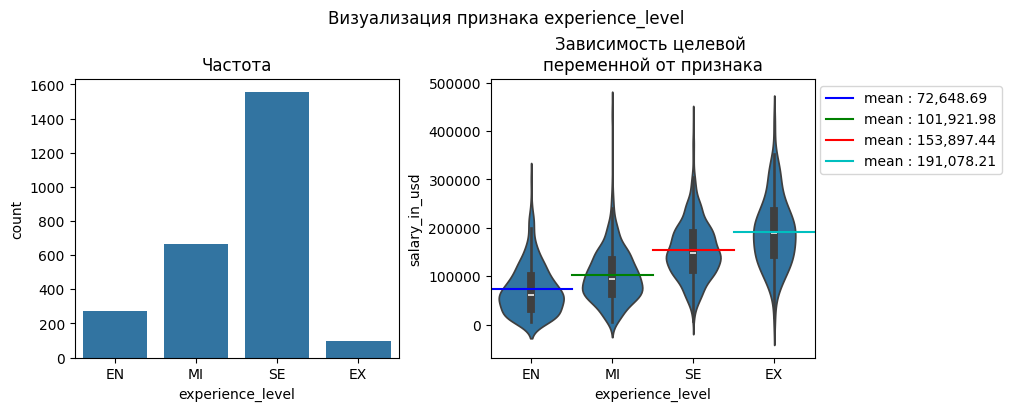

In [12]:
# Отобразим уровень зарплаты в USD в зависимости от уровня опыта
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
feature_name = 'experience_level'
uniq_features_value = ['EN', 'MI', 'SE', 'EX']
color_dict = dict(zip(uniq_features_value, colors))
# plt.figure(figsize=(5, 4))
fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g3 = sns.countplot(ax=axs[0], x=df[feature_name], order=uniq_features_value)
g3 = sns.violinplot(y=df[target_name], x=df[feature_name], order=uniq_features_value)
for i, el in enumerate(uniq_features_value):
    interval = 1/len(uniq_features_value)
    target_feature_mean = df.loc[df[feature_name] == el][target_name].mean()
    g3.axhline(target_feature_mean, color=color_dict[el] , xmin=i * interval, xmax=(i + 1) * interval, label=f"mean : {target_feature_mean:,.2f}")#, ls='--', label=f"mean : {target_feature_mean:,.2f}");
plt.legend(bbox_to_anchor=(1.6, 1));
axs[0].set_title('Частота')
axs[1].set_title('Зависимость целевой \nпеременной от признака');
# Наблюдаем, зависимость роста медианного и среднего значений значения целевой переменной при увеличении уровня.
# Преобразуем категориальный признак из строки в числовое значение имеющее естественную порядковую связь.
map_coder_features[feature_name] = {el:i for i, el in enumerate(uniq_features_value)}


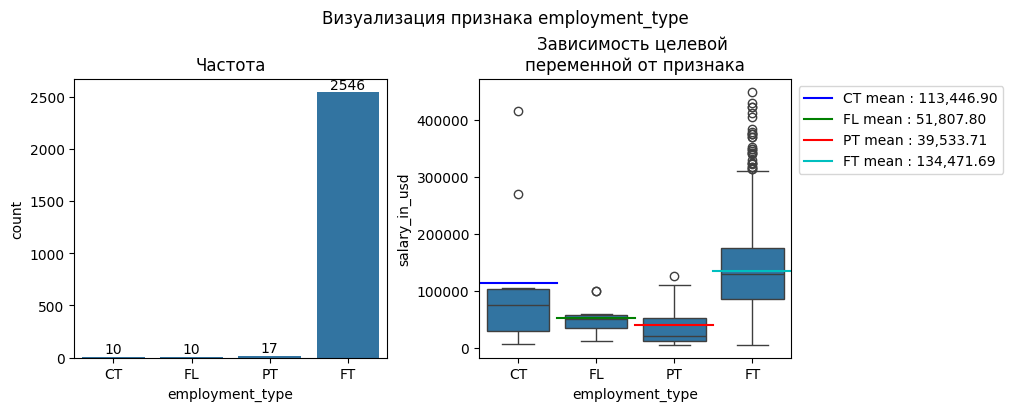

In [13]:
# Визуализируем признак Характер трудового договора
feature_name = 'employment_type'
vc = pd.DataFrame(df[feature_name].value_counts(ascending=True)).reset_index()
uniq_features_value = vc[feature_name].values
abs_values = vc['count'].values
color_dict = dict(zip(uniq_features_value, colors))
fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g4 = sns.countplot(ax=axs[0], x=df[feature_name], order=uniq_features_value, )
g4 = sns.boxplot(y=df[target_name], x=df[feature_name], order=uniq_features_value)
for i, el in enumerate(uniq_features_value):
    interval = 1/len(uniq_features_value)
    target_feature_mean = df.loc[df[feature_name] == el][target_name].mean()
    g4.axhline(target_feature_mean, color=color_dict[el] , xmin=i * interval, xmax=(i + 1) * interval, label=f"{el} mean : {target_feature_mean:,.2f}")#, ls='--', label=f"mean : {target_feature_mean:,.2f}");
plt.legend(bbox_to_anchor=(1.7, 1))
axs[0].bar_label(container=axs[0].containers[0], labels=abs_values)
axs[0].set_title('Частота')
axs[1].set_title('Зависимость целевой \nпеременной от признака');
# Наибоее часто встречающимся договор - полная занятость.
# Наиболее высокооплачиваемым договором является - полная занятость
# наблюдаем выбросы для договора контракт.
# Т.к. признак имеет фиксированный набор значений и этот набор небольшой, значения признака не имеют естественной порядковой связи закодируем признак через one hot encoder
if feature_name not in ohe_features:
    ohe_features.append(feature_name)


C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\1371322485.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\1371322485.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90);


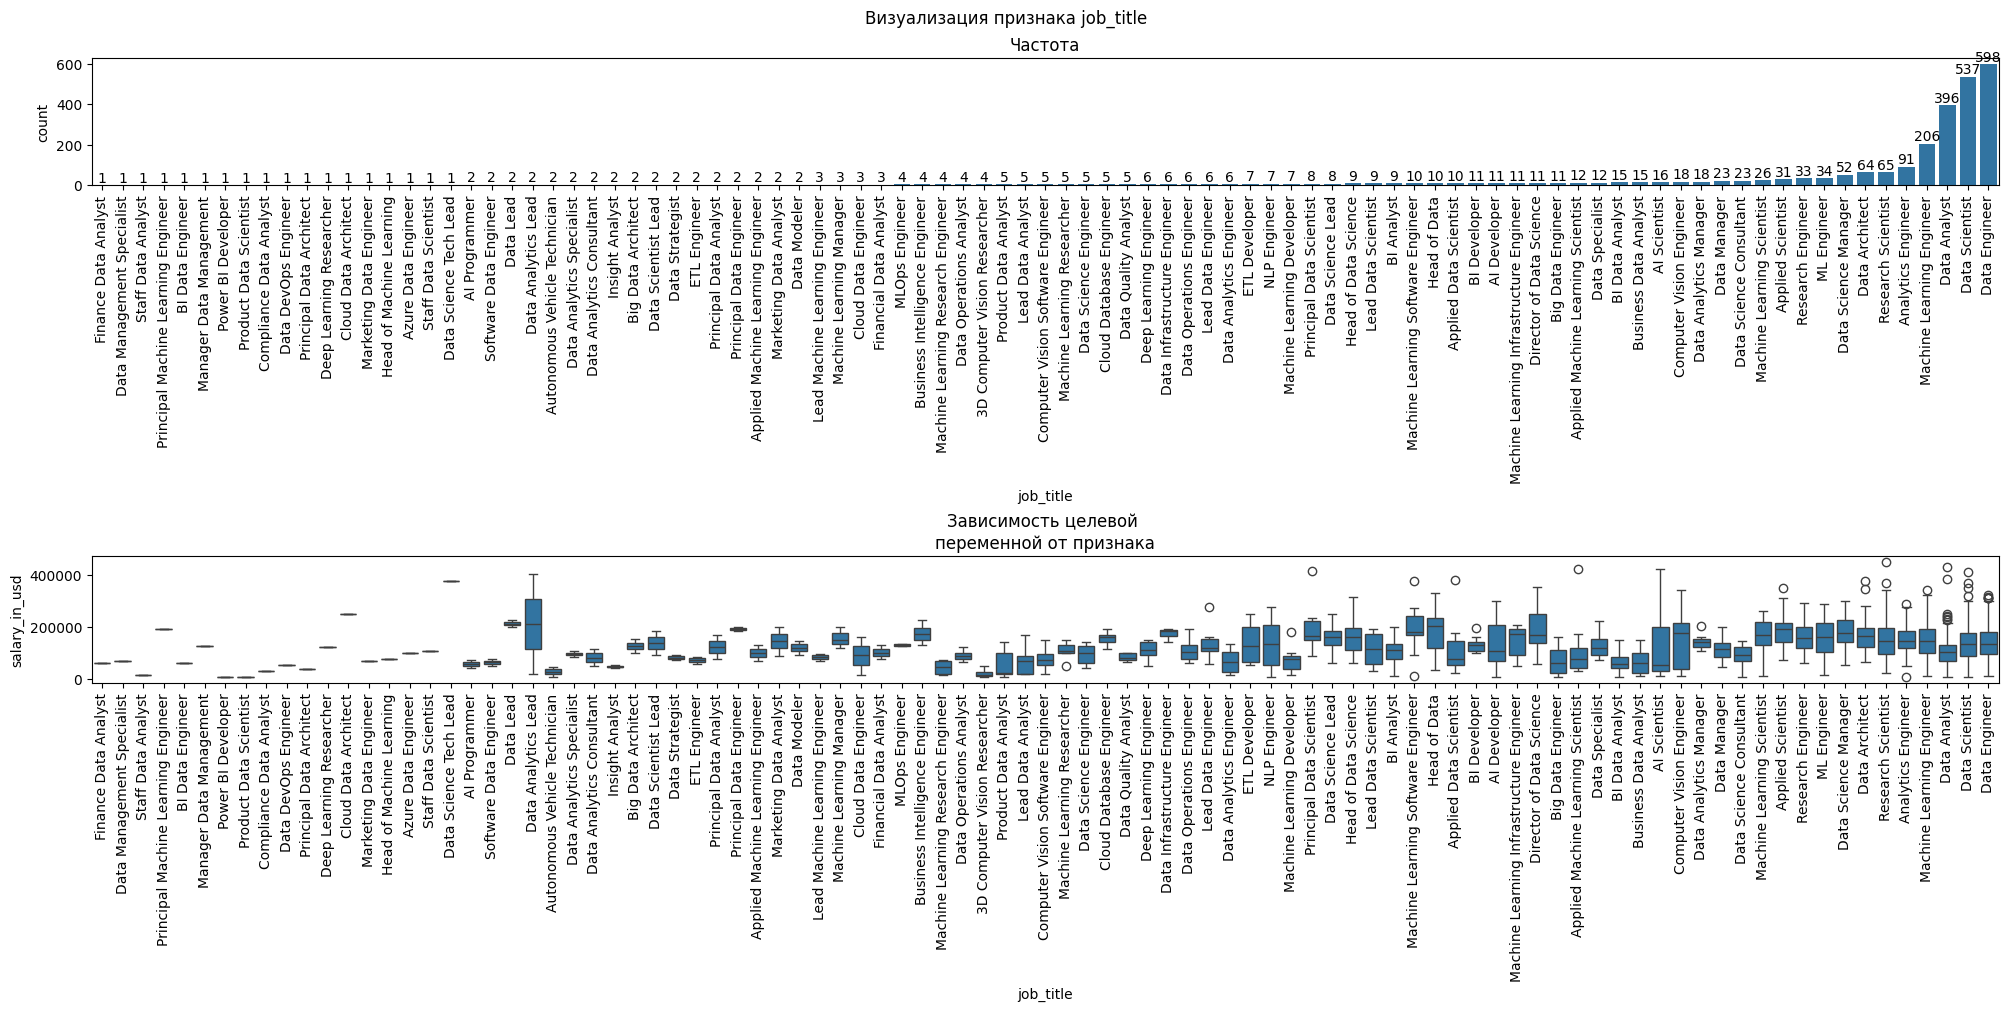

In [14]:
# Визуализируем признак job_category
feature_name = 'job_title'
vc = pd.DataFrame(df[feature_name].value_counts(ascending=True)).reset_index()
uniq_features_value = vc[feature_name].values
abs_values = vc['count'].values
# color_dict = dict(zip(uniq_features_value, colors))
fig, axs = plt.subplots(2, figsize=(20,10), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g5 = sns.countplot(ax=axs[0], x=df[feature_name], order=uniq_features_value)
g5 = sns.boxplot(ax=axs[1], y=df[target_name], x=df[feature_name], order=uniq_features_value)
# plt.legend(bbox_to_anchor=(1.7, 1))
axs[0].bar_label(container=axs[0].containers[0], labels=abs_values)
axs[0].set_title('Частота')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_title('Зависимость целевой \nпеременной от признака')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90);
# Очень большое количество категорий, сложно извлечь какую то информацию. 

In [15]:
# Сгруппируем значение признака job_title
job_categories = {
    'Data Scientist': ['Data Scientist', 'Applied Data Scientist', 'Data Scientist Lead', 'Lead Data Scientist', 'Data Science Lead', 'Applied Scientist', 'Machine Learning Scientist',\
                        'Data Science Consultant', 'Applied Machine Learning Scientist', 'Data Science Lead', 'Principal Data Scientist', 'Data Manager', 'Data Specialist', 'NLP Engineer'],
    'BI': ['BI Data Analyst', 'BI Developer', 'BI Analyst', 'BI Data Engineer', 'Power BI Developer', 'Business Intelligence Engineer'], 
    'Machine Learning Engineer': ['Machine Learning Engineer', 'ML Engineer', 'Machine Learning Researcher', 'Lead Machine Learning Engineer', 'Machine Learning Software Engineer',\
                                   'Machine Learning Developer', 'Deep Learning Engineer'],
    'Data Analyst': ['Data Analyst', 'Business Data Analyst', 'Marketing Data Analyst', 'Data Analytics Engineer'],
    'Data Engineer': ['Data Engineer', 'Big Data Engineer', 'Lead Data Engineer', 'Machine Learning Infrastructure Engineer'],
    'Research Scientist': ['Research Scientist', 'ML Researcher', 'Deep Learning Researcher'],
    'Manager': ['Data Analytics Manager', 'Head of Data', 'Machine Learning Manager', 'Director of Data Science', 'Head of Data Science', 'Data Science Manager'],
    'Engineer': ['Computer Vision Engineer', 'Computer Vision Software Engineer', 'Research Engineer', 'Analytics Engineer', 'Software Data Engineer', 'Data DevOps Engineer', 'Cloud Database Engineer', \
                 'ETL Developer', 'Cloud Data Engineer', 'Data Infrastructure Engineer', 'Data Operations Engineer', 'Data Science Engineer'],
    'AI Specialist': ['AI Developer', 'AI Scientist', 'AI Programmer'],
    'Architect': ['Data Architect', 'Big Data Architect', 'Cloud Data Architect']
}
# Создаем новый столбец job_category
df['job_category'] = 'Other'  # Значение по умолчанию для тех профессий, которые не попали в список

for category, titles in job_categories.items():
    df.loc[df['job_title'].isin(titles), 'job_category'] = category

df.loc[df['job_category'] == 'Other', 'job_title'].shape # 71 запись из 3755 отнесена к категории Other 

(71,)

C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\1143316975.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\1143316975.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45);


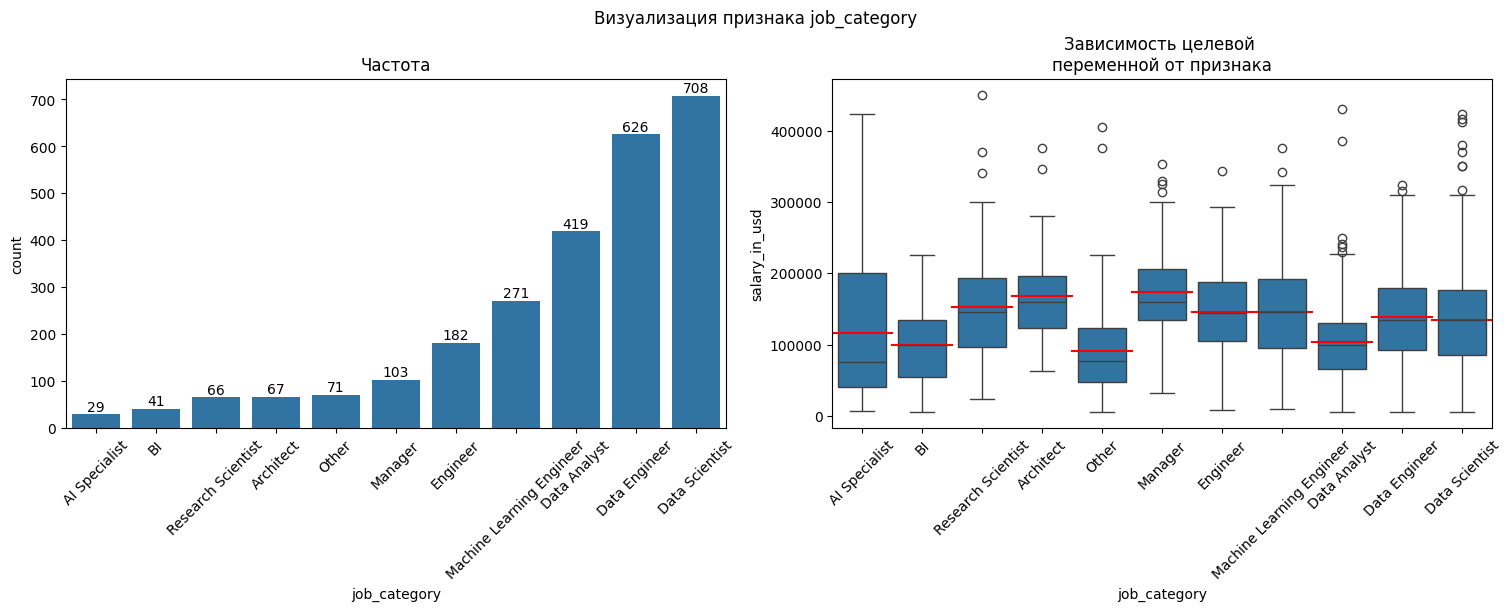

In [16]:
# Визуализируем признак job_category
feature_name = 'job_category'
vc = pd.DataFrame(df[feature_name].value_counts(ascending=True)).reset_index()
uniq_features_value = vc[feature_name].values
abs_values = vc['count'].values
# color_dict = dict(zip(uniq_features_value, colors))
fig, axs = plt.subplots(1, 2, figsize=(15,6), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g6 = sns.countplot(ax=axs[0], x=df[feature_name], order=uniq_features_value)
g6 = sns.boxplot(y=df[target_name], x=df[feature_name], order=uniq_features_value)
for i, el in enumerate(uniq_features_value):
    interval = 1/len(uniq_features_value)
    target_feature_mean = df.loc[df[feature_name] == el][target_name].mean()
    g6.axhline(target_feature_mean, color='red', xmin=i * interval, xmax=(i + 1) * interval, label=f"{el} mean : {target_feature_mean:,.2f}")#, ls='--', label=f"mean : {target_feature_mean:,.2f}");
# plt.legend(bbox_to_anchor=(1.7, 1))
axs[0].bar_label(container=axs[0].containers[0], labels=abs_values)
axs[0].set_title('Частота')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[1].set_title('Зависимость целевой \nпеременной от признака')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45);
# Наибоее часто встречающаяся категории Data Scientist, Data Engineer.
# Какой либо зависимости целевой переменной от признака не наблюдается.
# Т.к. признак имеет фиксированный набор значений и этот набор небольшой, значения признака не имеют естественной порядковой связи закодируем признак через one hot encoder
if feature_name not in ohe_features:
    ohe_features.append(feature_name)


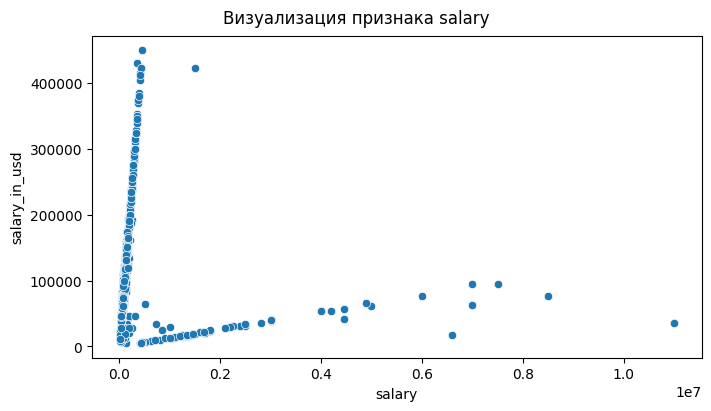

In [17]:
# Визуализируем признак salary
feature_name = 'salary'
fig, axs = plt.subplots(1, figsize=(7,4), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g7 = sns.scatterplot(ax=axs, x=df[feature_name], y=df[target_name])
# Никакой зависимости не наблюдается, предпооложительно, потому, что salary выражена в разных валютах

C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\2445867264.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=x_tick_rotation)
C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\2445867264.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=x_tick_rotation);


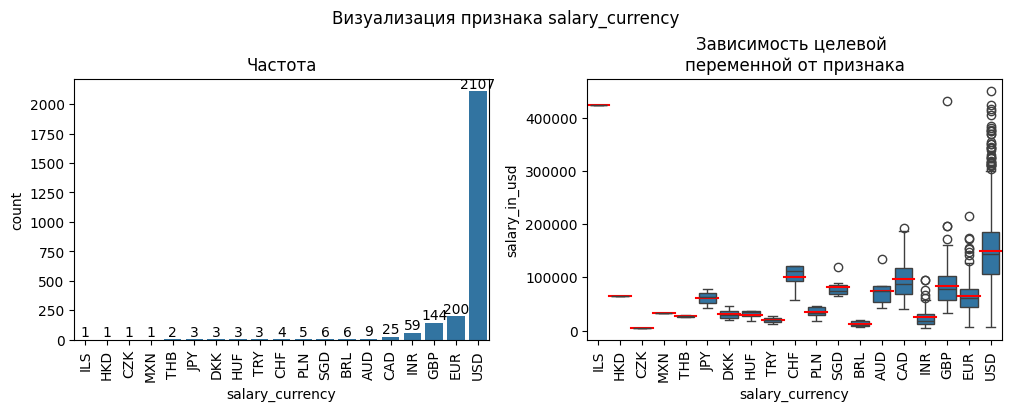

In [18]:
# Визуализируем признак Валюта, в которой выплачивается зарплата
feature_name = 'salary_currency'
x_tick_rotation = 90
vc = pd.DataFrame(df[feature_name].value_counts(ascending=True)).reset_index()
uniq_features_value = vc[feature_name].values
abs_values = vc['count'].values
fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g8 = sns.countplot(ax=axs[0], x=df[feature_name], order=uniq_features_value, )
g8 = sns.boxplot(y=df[target_name], x=df[feature_name], order=uniq_features_value)
for i, el in enumerate(uniq_features_value):
    interval = 1/len(uniq_features_value)
    target_feature_mean = df.loc[df[feature_name] == el][target_name].mean()
    g8.axhline(target_feature_mean, color='red' , xmin=i * interval, xmax=(i + 1) * interval, label=f"{el} mean : {target_feature_mean:,.2f}")#, ls='--', label=f"mean : {target_feature_mean:,.2f}");
# plt.legend(bbox_to_anchor=(1.7, 1))
axs[0].bar_label(container=axs[0].containers[0], labels=abs_values);
axs[0].set_title('Частота')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=x_tick_rotation)
axs[1].set_title('Зависимость целевой \nпеременной от признака');
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=x_tick_rotation);

# Наибоее часто встречающиеся валюта - USD, EUR, GBP.
# Явной зависимости целевой переменной от признака не наблюдается. Похоже, что зависимость отражает курс 
# наблюдаем значительные выбросы в сторону больших значений для валют USD, EUR.
if feature_name not in ohe_features:
    ohe_features.append(feature_name)

C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\2546465840.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\2546465840.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90);


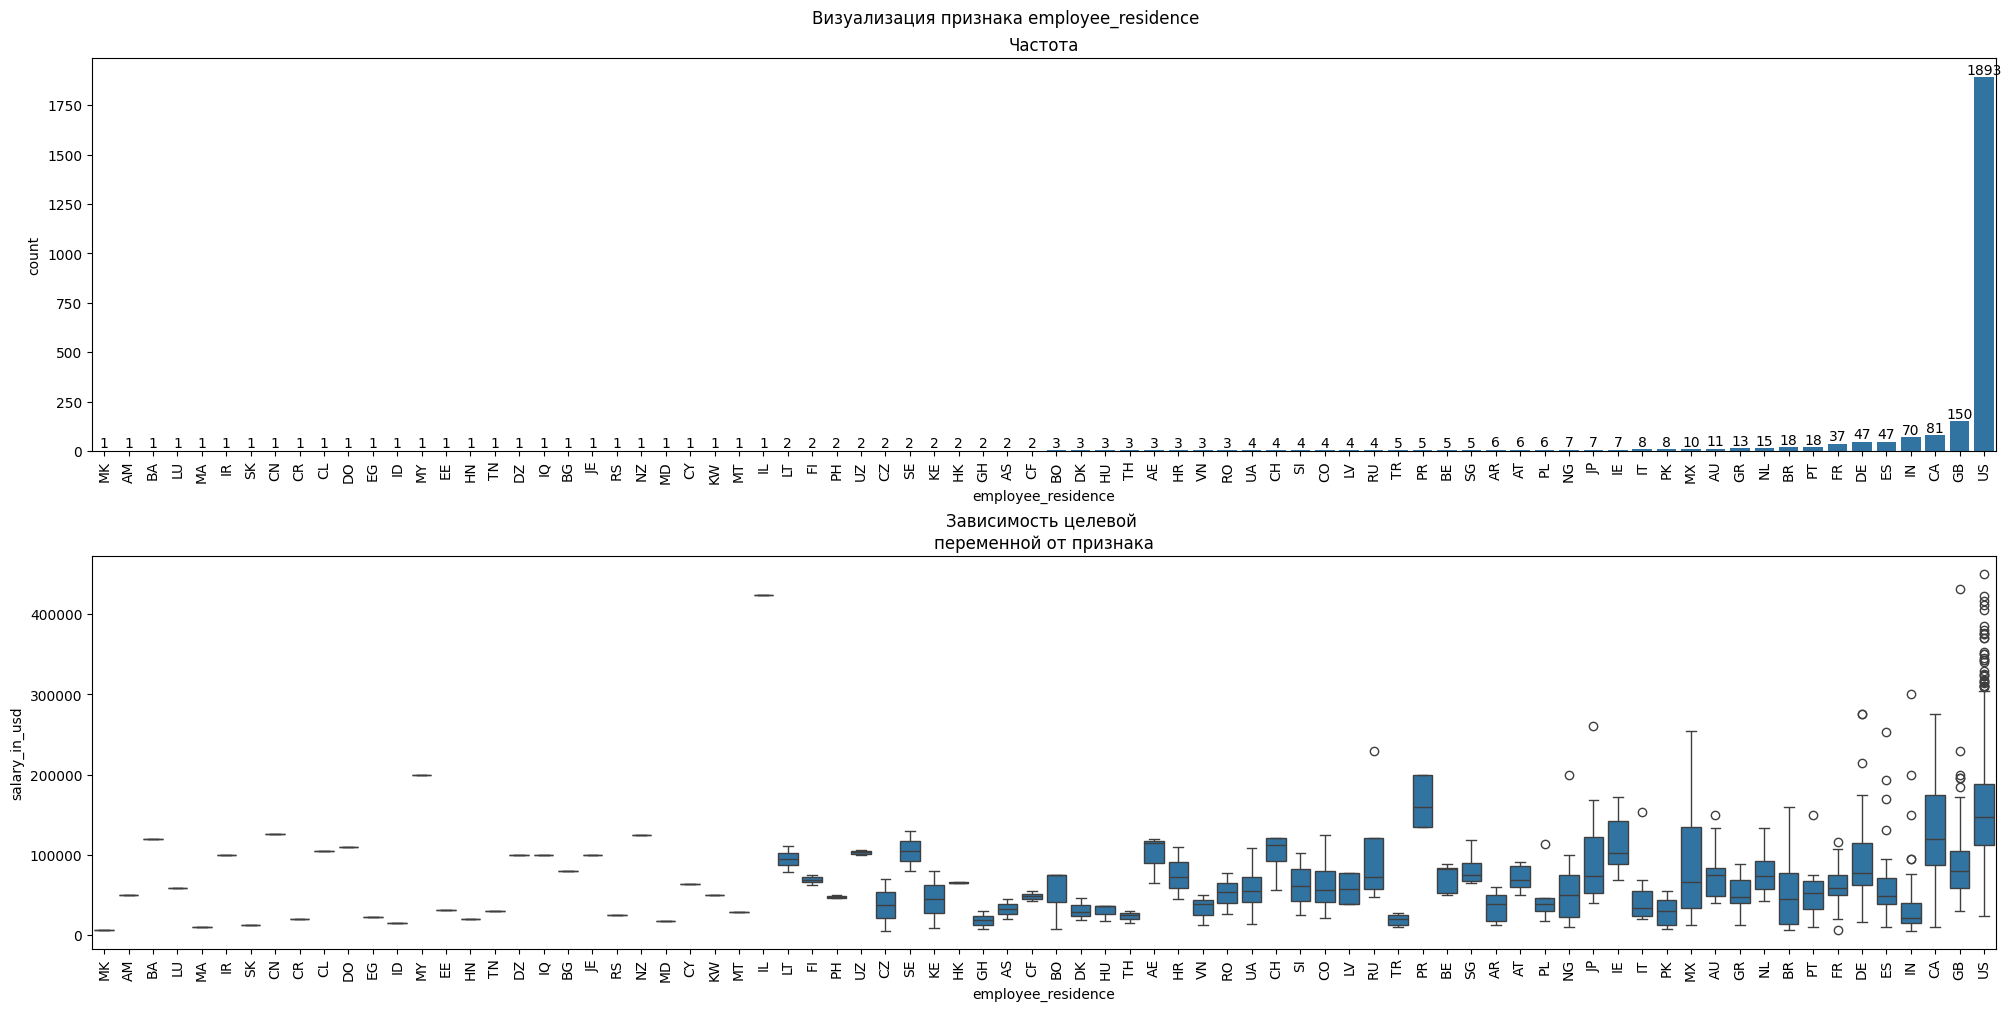

In [19]:
# Визуализируем признак employee_residence
feature_name = 'employee_residence'
vc = pd.DataFrame(df[feature_name].value_counts(ascending=True)).reset_index() #Сформируем датафрейм, содержащий уникальные значения их частоту
uniq_features_value = vc[feature_name].values
abs_values = vc['count'].values
# color_dict = dict(zip(uniq_features_value, colors))
fig, axs = plt.subplots(2, figsize=(20,10), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g9 = sns.countplot(ax=axs[0], x=df[feature_name], order=uniq_features_value)
g9 = sns.boxplot(ax=axs[1], y=df[target_name], x=df[feature_name], order=uniq_features_value)
# plt.legend(bbox_to_anchor=(1.7, 1))
axs[0].bar_label(container=axs[0].containers[0], labels=abs_values)
axs[0].set_title('Частота')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_title('Зависимость целевой \nпеременной от признака')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90);
# Очень большое количество категорий, сложно извлечь какую то информацию.
# Закодируем переменную через частотное кодирование.
map_coder_features[feature_name] = df[feature_name].value_counts().to_dict()

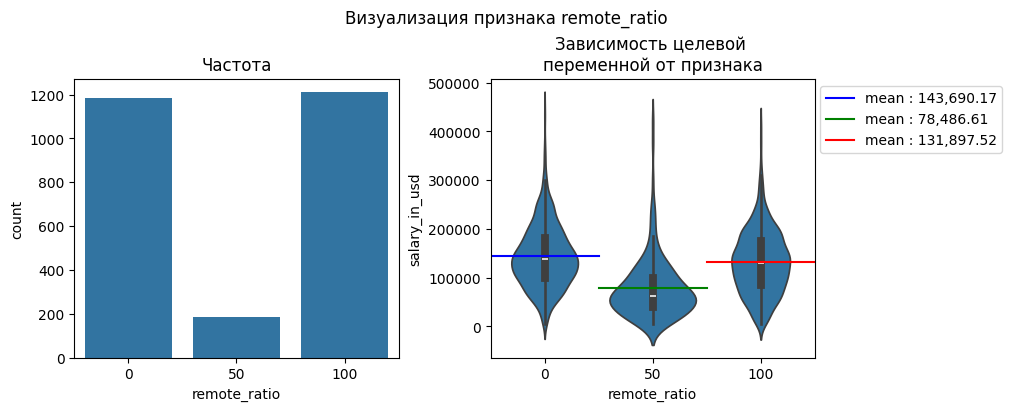

In [20]:
# Отобразим долю работы, выполненной удаленно
feature_name = 'remote_ratio'
vc = pd.DataFrame(df[feature_name].value_counts().reset_index()).sort_values(by=[feature_name])
uniq_features_value = vc[feature_name].values
abs_values = vc['count'].values
color_dict = dict(zip(uniq_features_value, colors))
fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g10 = sns.countplot(ax=axs[0], x=df[feature_name], order=uniq_features_value)
g10 = sns.violinplot(y=df[target_name], x=df[feature_name], order=uniq_features_value)
for i, el in enumerate(uniq_features_value):
    interval = 1/len(uniq_features_value)
    target_feature_mean = df.loc[df[feature_name] == el][target_name].mean()
    g10.axhline(target_feature_mean, color=color_dict[el] , xmin=i * interval, xmax=(i + 1) * interval, label=f"mean : {target_feature_mean:,.2f}")#, ls='--', label=f"mean : {target_feature_mean:,.2f}");
plt.legend(bbox_to_anchor=(1.6, 1));
axs[0].set_title('Частота')
axs[1].set_title('Зависимость целевой \nпеременной от признака');
# Большинство наблюдений имеют значение признака соответствующее полностью удаленной и полностью выполенной в офисе работе.
# Зависимость целевой переменной от признака скорее нелинейная.
# Не будем специально преобразовывать переменную к числовому виду, т.к. значения имеют естественную порядковую связь и при масштабировании будут приведены к одному масштабу

C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\3782615775.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
C:\Users\Alex\AppData\Local\Temp\ipykernel_5364\3782615775.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90);


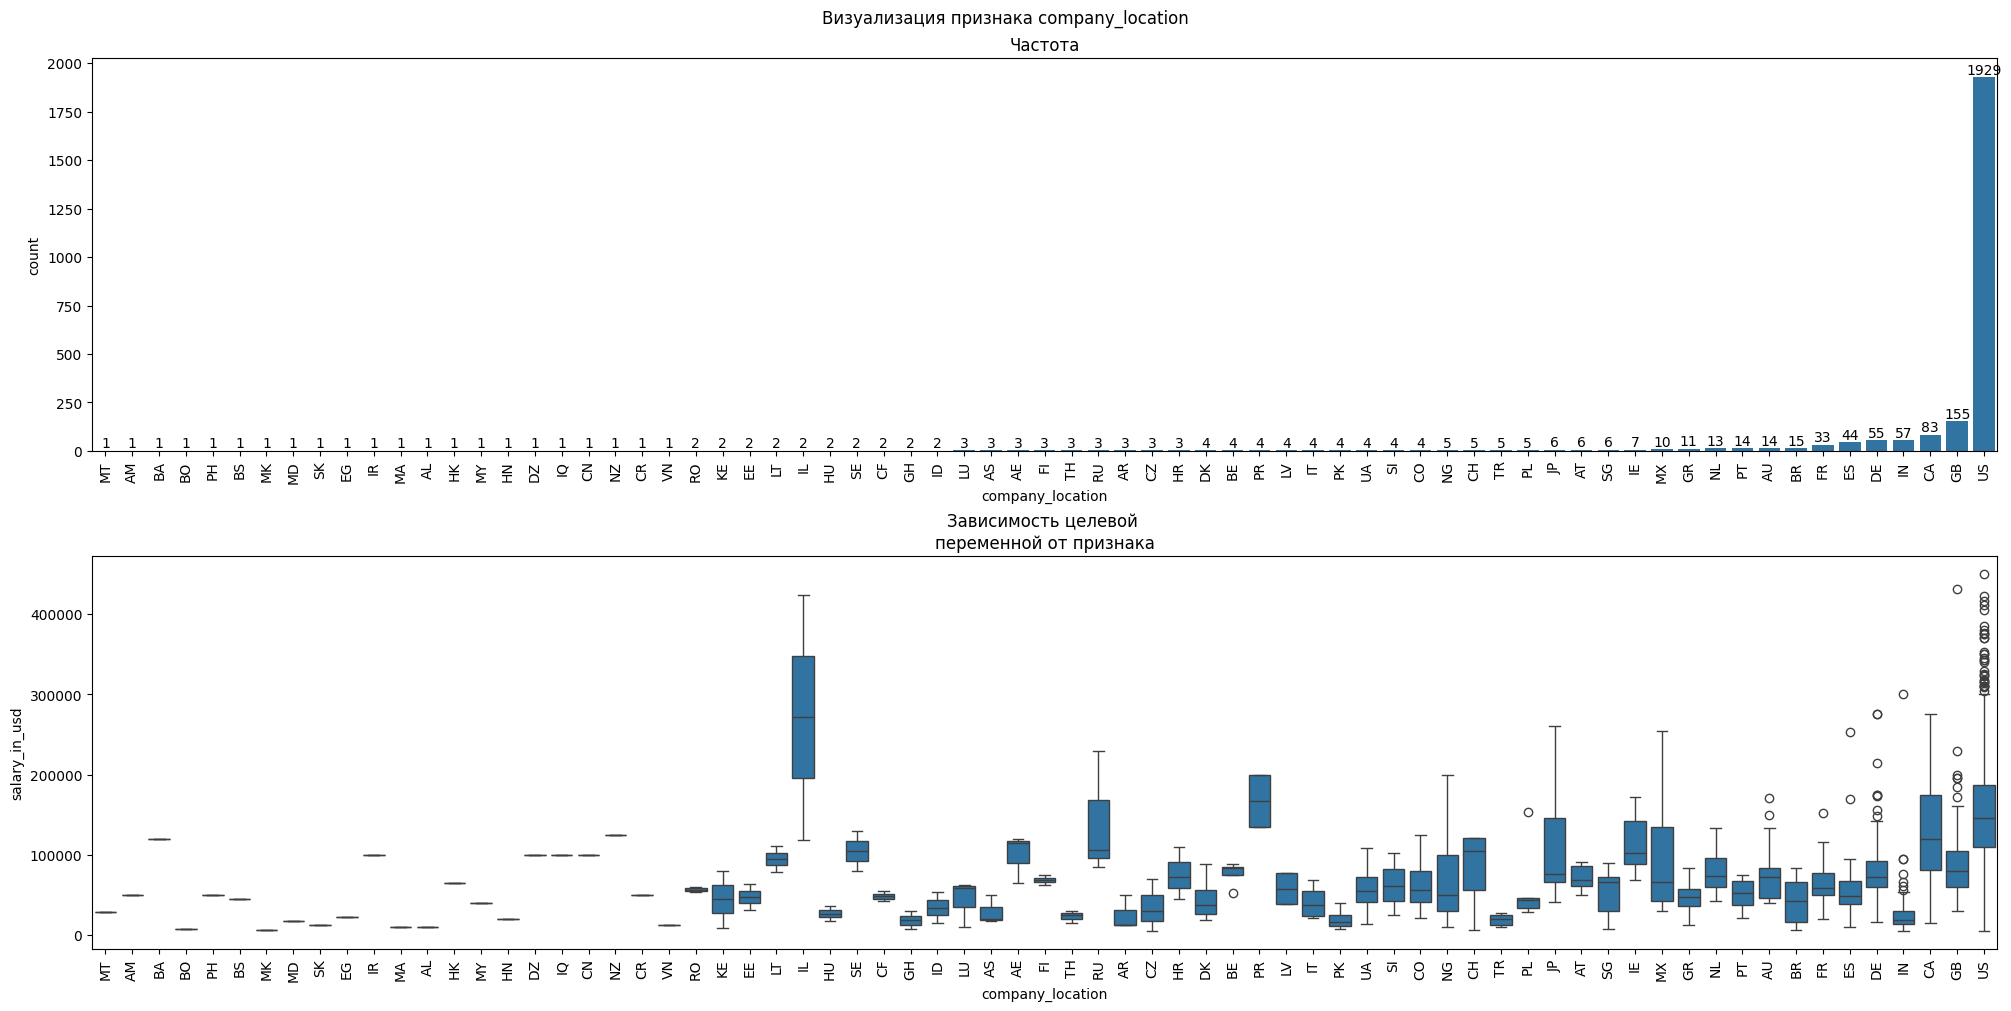

In [21]:
# Визуализируем признак company_location
feature_name = 'company_location'
vc = pd.DataFrame(df[feature_name].value_counts(ascending=True)).reset_index() #Сформируем датафрейм, содержащий уникальные значения их частоту
uniq_features_value = vc[feature_name].values
abs_values = vc['count'].values
# color_dict = dict(zip(uniq_features_value, colors))
fig, axs = plt.subplots(2, figsize=(20,10), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g11 = sns.countplot(ax=axs[0], x=df[feature_name], order=uniq_features_value)
g11 = sns.boxplot(ax=axs[1], y=df[target_name], x=df[feature_name], order=uniq_features_value)
# plt.legend(bbox_to_anchor=(1.7, 1))
axs[0].bar_label(container=axs[0].containers[0], labels=abs_values)
axs[0].set_title('Частота')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_title('Зависимость целевой \nпеременной от признака')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90);
# Очень большое количество категорий, сложно извлечь какую то информацию.
# Явной зависимости между значением признака и целевой переменной не наблюдается
# Закодируем переменную через частотное кодирование.
map_coder_features[feature_name] = df[feature_name].value_counts().to_dict()

# 

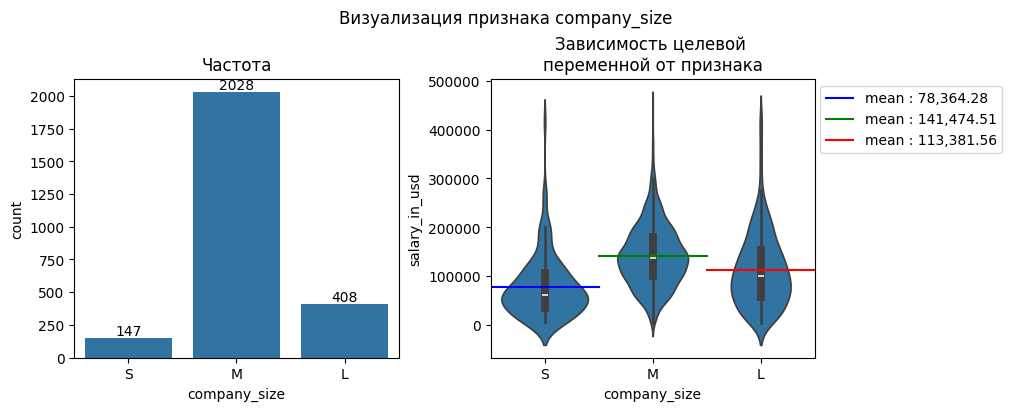

In [22]:
# Отобразим уровень зарплаты в USD в зависимости от размера компании
feature_name = 'company_size'
uniq_features_value = ['S', 'M', 'L']
abs_values = df[feature_name].value_counts().to_dict()
color_dict = dict(zip(uniq_features_value, colors))
fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True) #
fig.suptitle(f'Визуализация признака {feature_name}')
g12 = sns.countplot(ax=axs[0], x=df[feature_name], order=uniq_features_value)
g12 = sns.violinplot(y=df[target_name], x=df[feature_name], order=uniq_features_value)
for i, el in enumerate(uniq_features_value):
    interval = 1/len(uniq_features_value)
    target_feature_mean = df.loc[df[feature_name] == el][target_name].mean()
    g12.axhline(target_feature_mean, color=color_dict[el] , xmin=i * interval, xmax=(i + 1) * interval, label=f"mean : {target_feature_mean:,.2f}")#, ls='--', label=f"mean : {target_feature_mean:,.2f}");
plt.legend(bbox_to_anchor=(1.6, 1));
axs[0].bar_label(container=axs[0].containers[0], labels=[abs_values[el] for el in uniq_features_value])
axs[0].set_title('Частота')
axs[1].set_title('Зависимость целевой \nпеременной от признака');
# Не наблюдаем линейной зависимости от целевой переменной от признака.
# Преобразуем категориальный признак из строки в числовое значение имеющее естественную порядковую связь.
if feature_name not in ohe_features:
    ohe_features.append(feature_name)

In [23]:
# выполним кодирование признаков
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [24]:
# 1. через map
feature_name_suffix = '_cntenc'
for fn in map_coder_features.keys():
    new_feature_name = fn + feature_name_suffix
    if new_feature_name in df.columns:
        df.drop(columns=new_feature_name, inplace=True)
    print(fn)
    df[new_feature_name] = df[fn].map(map_coder_features[fn])
df.drop(columns=list(map_coder_features.keys())).head(5)


experience_level
employee_residence
company_location


,work_year,employment_type,job_title,salary,salary_currency,salary_in_usd,remote_ratio,company_size,job_category,experience_level_cntenc,employee_residence_cntenc,company_location_cntenc
0,2023,FT,Principal Data Scientist,80000,EUR,85847,100,L,Data Scientist,2,47,44
1,2023,CT,ML Engineer,30000,USD,30000,100,S,Machine Learning Engineer,1,1893,1929
2,2023,CT,ML Engineer,25500,USD,25500,100,S,Machine Learning Engineer,1,1893,1929
3,2023,FT,Data Scientist,175000,USD,175000,100,M,Data Scientist,2,81,83
4,2023,FT,Data Scientist,120000,USD,120000,100,M,Data Scientist,2,81,83


In [25]:
oh_encoder = OneHotEncoder(sparse_output = False)
oh_encoder.fit(df[ohe_features.copy()])
new_features_names = oh_encoder.get_feature_names_out()
if set(new_features_names).intersection(df.columns):
    df.drop(columns=new_features_names, inplace=True)
df = df.join(pd.DataFrame(oh_encoder.transform(df[ohe_features]), columns=new_features_names))
df[ohe_features + new_features_names.tolist()]#.drop(columns=ohe_features)

,employment_type,job_category,salary_currency,company_size,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,job_category_AI Specialist,job_category_Architect,...,salary_currency_JPY,salary_currency_MXN,salary_currency_PLN,salary_currency_SGD,salary_currency_THB,salary_currency_TRY,salary_currency_USD,company_size_L,company_size_M,company_size_S
0,FT,Data Scientist,EUR,L,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,CT,Machine Learning Engineer,USD,S,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,CT,Machine Learning Engineer,USD,S,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,FT,Data Scientist,USD,M,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,FT,Data Scientist,USD,M,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578,FT,Data Scientist,USD,L,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2579,FT,Data Scientist,USD,L,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2580,FT,Data Scientist,USD,S,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2581,CT,Data Analyst,USD,L,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [26]:
#df.drop(columns=list(map_coder_features.keys()) + ohe_features + ['job_title'], inplace=True)

In [27]:
y = df[target_name]
X = df.drop(columns=[target_name] + list(map_coder_features.keys()) + ohe_features + ['job_title']).copy()
X.shape, y.shape

((2583, 43), (2583,))

In [28]:
scaled_columns = ['work_year', 'salary', 'remote_ratio'] + [col + feature_name_suffix for col in map_coder_features.keys()]
print(scaled_columns)
scaler = MinMaxScaler()
X = X.drop(columns=scaled_columns).join(pd.DataFrame(scaler.fit_transform(X[scaled_columns].copy()), columns=scaled_columns))

['work_year', 'salary', 'remote_ratio', 'experience_level_cntenc', 'employee_residence_cntenc', 'company_location_cntenc']


2. Построение модели линейной регрессии:\
— Разделить данные на обучающую и тестовую выборки.\
— Построить модель линейной регрессии для прогнозирования заработной платы.\
— Оценить качество модели с помощью метрик MAE, MSE и R-квадрат.\
— Проанализировать значимость признаков и мультиколлинеарность.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42
                                                    , stratify=df[['work_year', 'experience_level']]
                                                    )
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2066, 43) (517, 43) (2066,) (517,)


In [31]:
df_result = pd.DataFrame({'model':[], 'sample':[], 'mae':[], 'mse':[], 'rmse':[], 'r2':[]})#.set_index(['model','sample'])
df_result_format = {'mae':'{:_.0f}', 'mse':'{:_.0f}', 'rmse':'{:_.0f}', 'r2':'{:.5f}'}


In [32]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [33]:

y_train_pred = model_lr.predict(X_train)
mse = mean_squared_error(y_train.values, y_train_pred)
mae = mean_absolute_error(y_train.values, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
model, sample = 'lr', 'train' 
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, np.NAN, r2]


<AxesSubplot: >

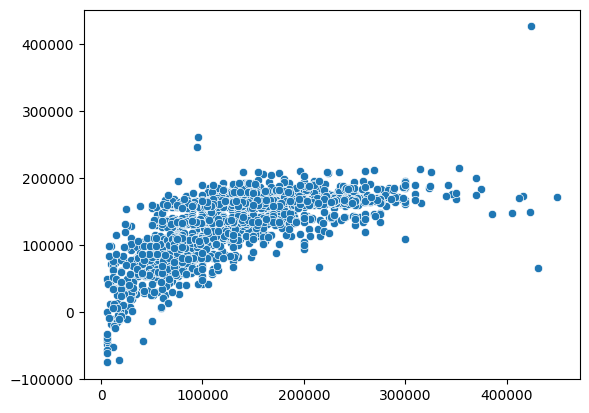

In [34]:
sns.scatterplot(x=y_train.values, y=y_train_pred)

In [35]:
# Результаты на тестовой выборке очень сильно отличаются от тренировочной. Модель обучается очень плохо. Имеется сильное переобучение.
# Причина в том, что в выборке присутствую данные, которые представлены только одним наблюдением, если такое наблюдение попадает в тестовую выборку
# Модель на тестовой выборке формирует прогнозы низкого качества.
y_test_pred = model_lr.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
model, sample = 'lr', 'test' 
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, np.NAN, r2]
df_result.style.format(df_result_format)

,model,sample,mae,mse,rmse,r2
0,lr,train,37_684,2_480_507_375,nan,0.45630
1,lr,test,362_431_364_930_447,67_911_307_532_840_349_316_268_737_691_648,nan,-15903646965791375491072.00000


<AxesSubplot: xlabel='salary_in_usd'>

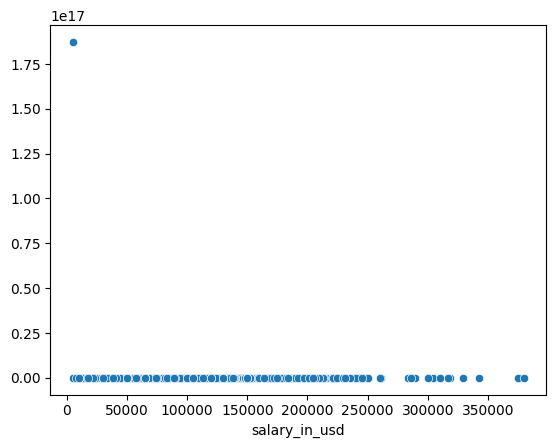

In [36]:
# Фактически одно или несколько наблюдений, которые не попали в обучающую выборку приводят к тому, что именно на этих наблюдениях модель сильно ошибается.
sns.scatterplot(x=y_test, y=y_test_pred)


In [37]:
# pd.DataFrame(zip(y_test.values,y_test_pred), columns=['real', 'pred']).sort_values(by='pred')
# pd.DataFrame({'real':y_test.values,'pred': y_test_pred})#.sort_values(by='pred')

In [38]:
# Отобразим наблюдения, которые дают большую ошибку.
# pd.merge(X_test.reset_index(), pd.DataFrame({target_name:y_test_pred}), how='left', left_index=True, right_index=True).query('salary_in_usd > 8.43063605e+16')
cond = 'salary_in_usd >' + str(y_test_pred.max()/10)
print(y_test_pred.max(), cond)
pd.merge(X_test.reset_index(), pd.DataFrame({target_name:y_test_pred}), how='left', left_index=True, right_index=True).query(cond)

1.8737701565154778e+17 salary_in_usd >1.8737701565154776e+16


,index,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,job_category_AI Specialist,job_category_Architect,job_category_BI,job_category_Data Analyst,job_category_Data Engineer,...,company_size_L,company_size_M,company_size_S,work_year,salary,remote_ratio,experience_level_cntenc,employee_residence_cntenc,company_location_cntenc,salary_in_usd
507,1759,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.666667,0.010369,1.0,0.333333,0.000529,0.001037,1.873770e+17


In [39]:
# Видим, что это валюта CZK, которая в датасете была преставлена одним наблюдением.
# df.loc[df['salary']>=30400000]
# df.loc[df['salary_currency'] == 'CLP']
df.iloc[pd.merge(X_test.reset_index(), pd.DataFrame({target_name:y_test_pred}), how='left', left_index=True, right_index=True).query(cond)['index'].values]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,salary_currency_JPY,salary_currency_MXN,salary_currency_PLN,salary_currency_SGD,salary_currency_THB,salary_currency_TRY,salary_currency_USD,company_size_L,company_size_M,company_size_S
1759,2022,MI,FT,NLP Engineer,120000,CZK,5132,CZ,100,CZ,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


— Проанализировать значимость признаков и мультиколлинеарность.

In [40]:
# Самый простой способ определить значимость признаков регрессионной модели - посмотреть на значения коэффициентов модели.
coefficients = model_lr.coef_
# odds_ratios = np.exp(coefficients)

# Display feature importance using coefficients and odds ratios
feature_importance_lr = pd.DataFrame({
    'Feature': X.columns
    ,'Coefficient': coefficients
    # ,'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient):")
print(feature_importance_lr.sort_values(by='Coefficient', ascending=False))

# Наибольшими значениями обладают коэффициенты из группы salary_currency и company_size. Числовой признак  salary находится на 26 месте.
#  Но на самом деле самым важным признаком будет именно  salary т.к. именно от этого  признака определяется значение salary_usd и без этого признака модель работать не будет.


Feature Importance (Coefficient):
                                   Feature   Coefficient
2                       employment_type_FT  8.484286e+17
3                       employment_type_PT  8.484286e+17
0                       employment_type_CT  8.484286e+17
1                       employment_type_FL  8.484286e+17
14         job_category_Research Scientist  1.494141e+17
4               job_category_AI Specialist  1.494141e+17
12                    job_category_Manager  1.494141e+17
11  job_category_Machine Learning Engineer  1.494141e+17
5                   job_category_Architect  1.494141e+17
10                   job_category_Engineer  1.494141e+17
9              job_category_Data Scientist  1.494141e+17
8               job_category_Data Engineer  1.494141e+17
6                          job_category_BI  1.494141e+17
13                      job_category_Other  1.494141e+17
7                job_category_Data Analyst  1.494141e+17
38                                  salary  3.608160e

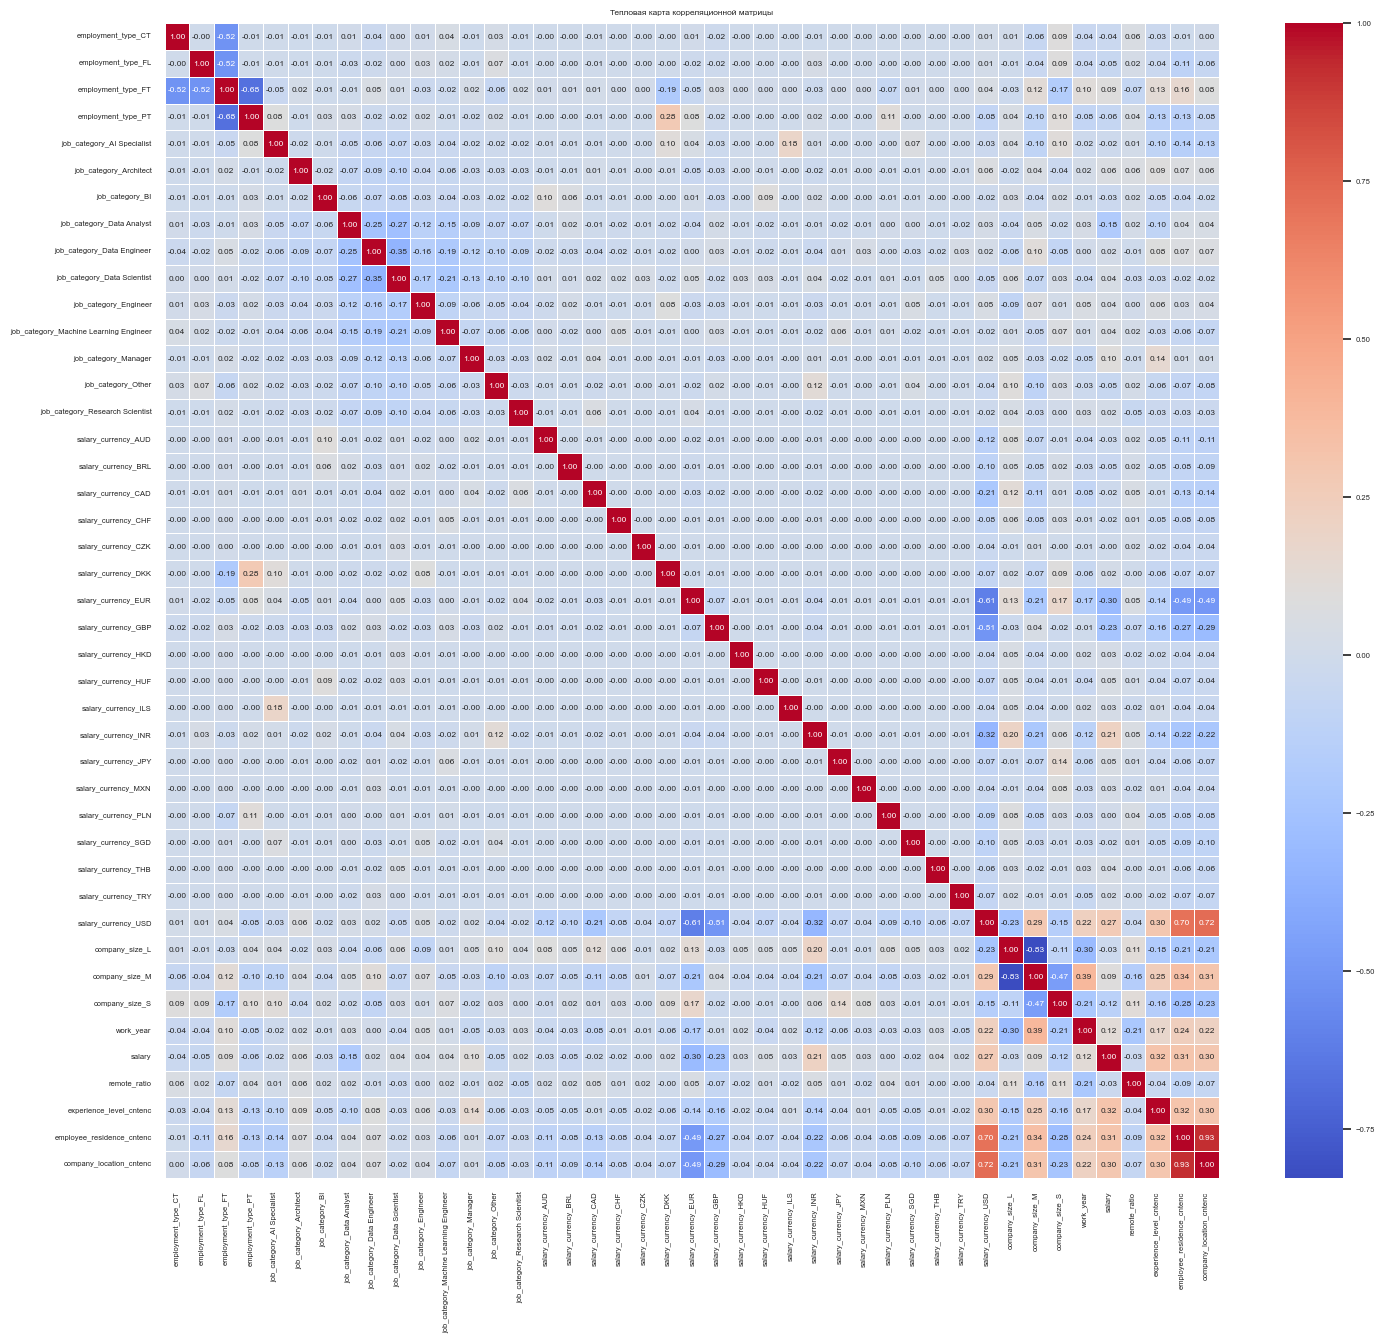

In [41]:
# Мультиколлинеарность - совместная или множественная взаимозависимость объясняющих переменных
# Для исследования мультиколлинеарности отобразим корреляционную матрицу
# Датасет с подготовленными признаками содержит каких то существенных корреляций. 
# Исключением может быть корреляция между:
# - элементами закодированными признаками employment_type
# - company_location и employee_residence т.к. большинство компаний и сотрудников имеют признак US
# company_location, employee_residence и salary_currency_usd по причине того, что большинство компаний и сотрудников имеют признак US

correlation_matrix = X.corr(method='kendall')
plt.figure(figsize=(17, 15))
sns.set(font_scale=0.5)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Тепловая карта корреляционной матрицы")
plt.show()
sns.set(font_scale=1)



3. Построение модели дерева решений:\
— Построить модель дерева решений для прогнозирования заработной платы.\
— Оценить качество модели с помощью метрик RMSE и R-квадрат.\
— Подберите гиперпараметры для модели дерево решений\
— Визуализировать дерево решений.

In [42]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text, plot_tree
import graphviz

In [43]:
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)
y_train_pred = model_dt.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
rmse = mse**0.5
r2 = r2_score(y_train, y_train_pred)
model, sample = 'dtr', 'train'
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, rmse, r2]
df_result.style.format(df_result_format)

,model,sample,mae,mse,rmse,r2
0,lr,train,37_684,2_480_507_375,nan,0.45630
1,lr,test,362_431_364_930_447,67_911_307_532_840_349_316_268_737_691_648,nan,-15903646965791375491072.00000
2,dtr,train,0,0,0,1.00000


In [44]:
y_test_pred = model_dt.predict(X_test)
mse = mean_squared_error(y_test.values, y_test_pred)
mae = mean_absolute_error(y_test.values, y_test_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_test_pred)
model, sample = 'dtr', 'test' 
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, rmse, r2]
df_result.style.format(df_result_format)
# Модель на тренировочном датасете показывает нулевую ошибку и значение коэффициента детерминации (ожидаемо), равное 1.
# На тестовом датасете качество модели падает, но незначительно.
# Причина в том, что в модели присутствует много признаков закодированных через OHE.
# Эти признаки подходят для формирования дерева лучше, чем для построения гиперплоскости.
# Даже простая модель состоящая из одного дерева с параметрами по умолчанию, показывает очень хорошие результаты.

,model,sample,mae,mse,rmse,r2
0,lr,train,37_684,2_480_507_375,nan,0.45630
1,lr,test,362_431_364_930_447,67_911_307_532_840_349_316_268_737_691_648,nan,-15903646965791375491072.00000
2,dtr,train,0,0,0,1.00000
3,dtr,test,1_268,65_181_356,8_073,0.98474


In [45]:
# Попробуем еще улучшить модель, подберем гиперпараметры модели
df_result_dtr = pd.DataFrame({'depth':[], 'split':[], 'leaf':[], 'rmse':[], 'r2':[]})
depths = [3, 5, 7, 9, 10] # - глубина дерева
splits = [2, 5, 10, 15, 20] #- минимальное число образцов в узле
samples_leaf = [1, 2, 3, 4, 5] # - минимальное число наблюдений в листе 
for depth in depths:
    for split in splits:
      for leaf in samples_leaf:
        model_dt = DecisionTreeRegressor(max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=42)
        model_dt.fit(X_train, y_train)
        y_test_pred = model_dt.predict(X_test)
        rmse = mean_squared_error(y_test, y_test_pred)**0.5
        r2 = r2_score(y_test, y_test_pred)
        df_result_dtr.loc[len(df_result_dtr.index)] = [depth, split, leaf, rmse, r2]
# print(f"Глубина дерева: {depth}, минимальное число образцов в узле: {split}, минимальное количество образцов {leaf}, rmse: {mse:_.0f} R^2: {r2:.5f}")

In [46]:
# Максимальное качество модели на тестовой выборке достигается при гиперпараметрах с максимально глубоким деревом и минимальным количествм наблюдений в листе.
# Что говорит о том, что модель пытается "заучить" данные тренировочноый выборки.
# Тем не менее удалось еще немного улучшить показатели модели по сравнению с моделью, обученной с параметрами по умолчанию.
df_result_dtr.sort_values(by=['rmse'], ascending=True).head(5).style.format({'depth':'{:.0f}','split':'{:.0f}','leaf':'{:.0f}', 'rmse':'{:_.0f}'})

,depth,split,leaf,rmse,r2
100,10,2,1,7_989,0.985053
105,10,5,1,8_001,0.985009
120,10,20,1,8_116,0.984573
115,10,15,1,8_167,0.984380
80,9,5,1,8_228,0.984147


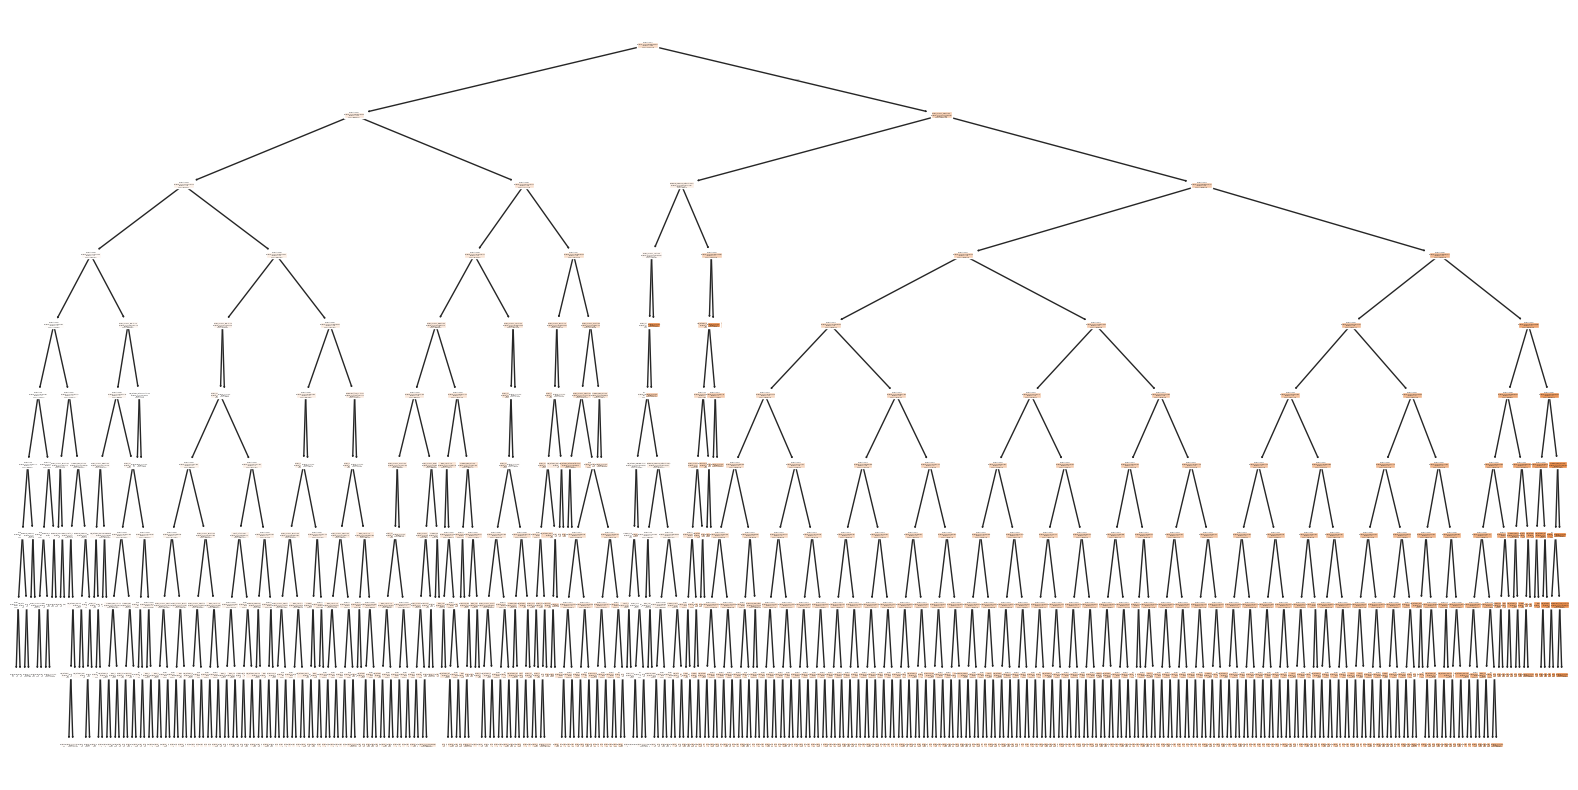

In [47]:
# Визуализируем дерево
model_dt = DecisionTreeRegressor(max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)
model_dt.fit(X_train, y_train)
# export_graphviz не запустился
plt.figure(figsize=(20, 10))
plot_tree(model_dt, feature_names=X.columns, class_names=y_test, filled=True)
plt.show()

4. Построение ансамблевой модели:\
— Построить ансамблевую модель, используя Random Forest и Boosting.\
— Сравнить качество ансамблевой модели с отдельными моделями.\
— Оценить важность признаков в ансамблевой модели.

In [48]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [49]:
model_dt = RandomForestRegressor()
model_dt.fit(X_train, y_train)
y_train_pred = model_dt.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
rmse = mse**0.5
r2 = r2_score(y_train, y_train_pred)
model, sample = 'rf', 'train'
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, rmse, r2]

feature_importances_rf = pd.Series(model_dt.feature_importances_, index=X_train.columns)

y_test_pred = model_dt.predict(X_test)
mse = mean_squared_error(y_test.values, y_test_pred)
mae = mean_absolute_error(y_test.values, y_test_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_test_pred)
model, sample = 'rf', 'test' 
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, rmse, r2]
df_result.style.format(df_result_format)


,model,sample,mae,mse,rmse,r2
0,lr,train,37_684,2_480_507_375,nan,0.45630
1,lr,test,362_431_364_930_447,67_911_307_532_840_349_316_268_737_691_648,nan,-15903646965791375491072.00000
2,dtr,train,0,0,0,1.00000
3,dtr,test,1_268,65_181_356,8_073,0.98474
4,rf,train,864,30_534_927,5_526,0.99331
5,rf,test,1_769,81_857_277,9_048,0.98083


In [50]:
# Отбор 10 наиболее важных признаков
top_features = feature_importances_rf.nlargest(10).index
top_features

Index(['salary', 'salary_currency_USD', 'salary_currency_INR',
       'employee_residence_cntenc', 'company_location_cntenc',
       'salary_currency_ILS', 'salary_currency_GBP', 'salary_currency_TRY',
       'salary_currency_PLN', 'salary_currency_THB'],
      dtype='object')

In [51]:
model_dt = GradientBoostingRegressor()
model_dt.fit(X_train, y_train)
y_train_pred = model_dt.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
rmse = mse**0.5
r2 = r2_score(y_train, y_train_pred)
model, sample = 'gbr', 'train'
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, rmse, r2]

feature_importances_gbr = pd.Series(model_dt.feature_importances_, index=X_train.columns)

y_test_pred = model_dt.predict(X_test)
mse = mean_squared_error(y_test.values, y_test_pred)
mae = mean_absolute_error(y_test.values, y_test_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_test_pred)
model, sample = 'gbr', 'test' 
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, rmse, r2]
df_result.style.format(df_result_format)

,model,sample,mae,mse,rmse,r2
0,lr,train,37_684,2_480_507_375,nan,0.45630
1,lr,test,362_431_364_930_447,67_911_307_532_840_349_316_268_737_691_648,nan,-15903646965791375491072.00000
2,dtr,train,0,0,0,1.00000
3,dtr,test,1_268,65_181_356,8_073,0.98474
4,rf,train,864,30_534_927,5_526,0.99331
5,rf,test,1_769,81_857_277,9_048,0.98083
6,gbr,train,2_087,16_372_257,4_046,0.99641
7,gbr,test,2_525,49_793_254,7_056,0.98834


In [52]:
# Применение ансамблевых моделей с параметрами по умолчанию:
#  - переобучение ожидаемо снизилось, обобщающая способность модели увеличилась
#  - есть ожидание, что на наблюдениях с таким сочетанием признаков, которые отсутствовали в обучающей выборке на нестовой выборке модель будет давать меньшую ошибку.
# Тем не менее проста модель на основе алгоритма дерева решений на тестовой выборке показала немного лучший результат, чем ансамблевый метод Случайный лес.
# Модель на основе алгоритма градиентного бустинга, показала самые лучшче результаты на тестовой выборке среди всех моделей.
# С т.з. переобучения модель на основе алгоритма градиентного бустинга тоже показала наилучшие результаты.

In [53]:
# Отобразим топ 10 наиболее важных признаков для каждой модели
pd.DataFrame({'feature_importances_rf': feature_importances_rf.sort_values(ascending=False).index,\
               'feature_importances_gbr': feature_importances_gbr.sort_values(ascending=False).index}).head(10)

,feature_importances_rf,feature_importances_gbr
0,salary,salary
1,salary_currency_USD,salary_currency_USD
2,salary_currency_INR,salary_currency_INR
3,employee_residence_cntenc,employee_residence_cntenc
4,company_location_cntenc,salary_currency_ILS
5,salary_currency_ILS,salary_currency_GBP
6,salary_currency_GBP,salary_currency_EUR
7,salary_currency_TRY,salary_currency_PLN
8,salary_currency_PLN,salary_currency_TRY
9,salary_currency_THB,salary_currency_BRL


In [54]:
# Видим, что самым важным  признаком явялется salary, как и предполагалось.
# Далее идут признаки относящиеся к группе salary_currency и employee_residence

5. Понижение размерности:\
— Применить Principal Component Analysis (PCA) для снижения размерности данных.\
— Построить модель линейной регрессии с использованием данных, полученных после PCA.\
— Сравнить качество модели с использованием исходных данных.\

In [55]:
from sklearn.decomposition import PCA

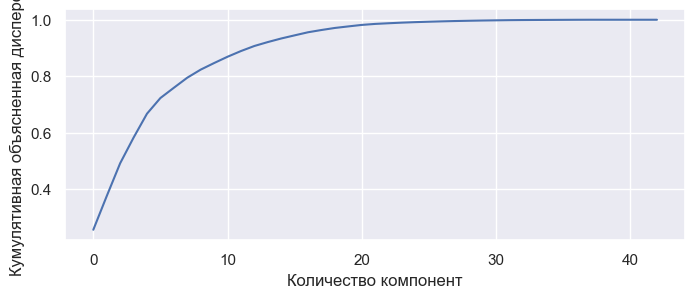

In [56]:
# Попробуем подобрать оптимальное количество компонентов с т.з. сохранения информации.
model_pca = PCA().fit(X_train)
plt.figure(figsize=(8,3))
plt.plot(np.cumsum(model_pca.explained_variance_ratio_))
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.show()
# При сокращении компонентов до 25 сохранится практическии вся информация.

In [57]:
model_pca = PCA(n_components=25)
model_pca.fit(X_train)
X_train_pca = model_pca.transform(X_train)

model_lr = LinearRegression()
model_lr.fit(X_train_pca, y_train)

y_train_pred = model_lr.predict(X_train_pca)
mse = mean_squared_error(y_train.values, y_train_pred)
mae = mean_absolute_error(y_train.values, y_train_pred)
rmse = mse**0.5
r2 = r2_score(y_train, y_train_pred)
model, sample = 'lr_pca_25', 'train' 
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, rmse, r2]

X_test_pca = model_pca.transform(X_test)

y_test_pred = model_lr.predict(X_test_pca)
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
model, sample = 'lr_pca_25', 'test' 
df_result = df_result.loc[(df_result['model'] != model) | (df_result['sample'] != sample)].reset_index(drop=True)
df_result.loc[len(df_result.index)] = [model, sample, mae, mse, rmse, r2]
df_result.style.format(df_result_format)

,model,sample,mae,mse,rmse,r2
0,lr,train,37_684,2_480_507_375,nan,0.45630
1,lr,test,362_431_364_930_447,67_911_307_532_840_349_316_268_737_691_648,nan,-15903646965791375491072.00000
2,dtr,train,0,0,0,1.00000
3,dtr,test,1_268,65_181_356,8_073,0.98474
4,rf,train,864,30_534_927,5_526,0.99331
5,rf,test,1_769,81_857_277,9_048,0.98083
6,gbr,train,2_087,16_372_257,4_046,0.99641
7,gbr,test,2_525,49_793_254,7_056,0.98834
8,lr_pca_25,train,38_445,2_618_015_647,51_167,0.42616
9,lr_pca_25,test,34_907,2_173_245_348,51_167,0.49106


In [58]:
# Снижение количества признаков благоприятно повлияло на обобщающую способность модели. 
# Результаты на обучающей выборке практически не изменились
# Результаты на тестовой выборке улучшились значительно.
# Переобучение практические не наблюдается.
# Хотя качество самой модели значительно хуже, чем у моделей на основе алгоримов DecisionTree

7. Кластеризация:\
— Применить метод K-Means для кластеризации данных по заработной плате.\
— Определить оптимальное количество кластеров.\
— Проанализировать характеристики полученных кластеров.\
— Визуализировать результаты кластеризации и проанализировать характеристики в каждом кластере.\
— Проанализируйте полученные данные и сделайте выводы о том, какой алгоритм кластеризации сможет выделить кластеры лучше, чем K-Means.

In [59]:
from sklearn.cluster import KMeans
import plotly.express as px

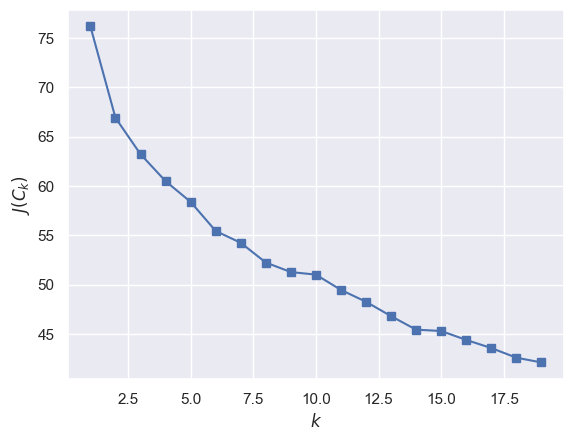

In [60]:
# Определим оптимальное количество кластеров
inertia = []
max_clusters = 20
for k in range(1, max_clusters):
    model_kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(X)
    inertia.append(np.sqrt(model_kmeans.inertia_))

plt.plot(range(1, max_clusters), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

In [61]:
pca_2 = PCA(n_components=2, random_state=42)

kmeans = KMeans(n_clusters=15, random_state=42, n_init='auto').fit(X)
# pca_2.fit(X)
centroids_pca = pca_2.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

# principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X)) - Если, что то здесь ошибка в материалах лекции. Не нужно повторно обучать модель.
principal_df = pd.DataFrame(data = pca_2.transform(X))

c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


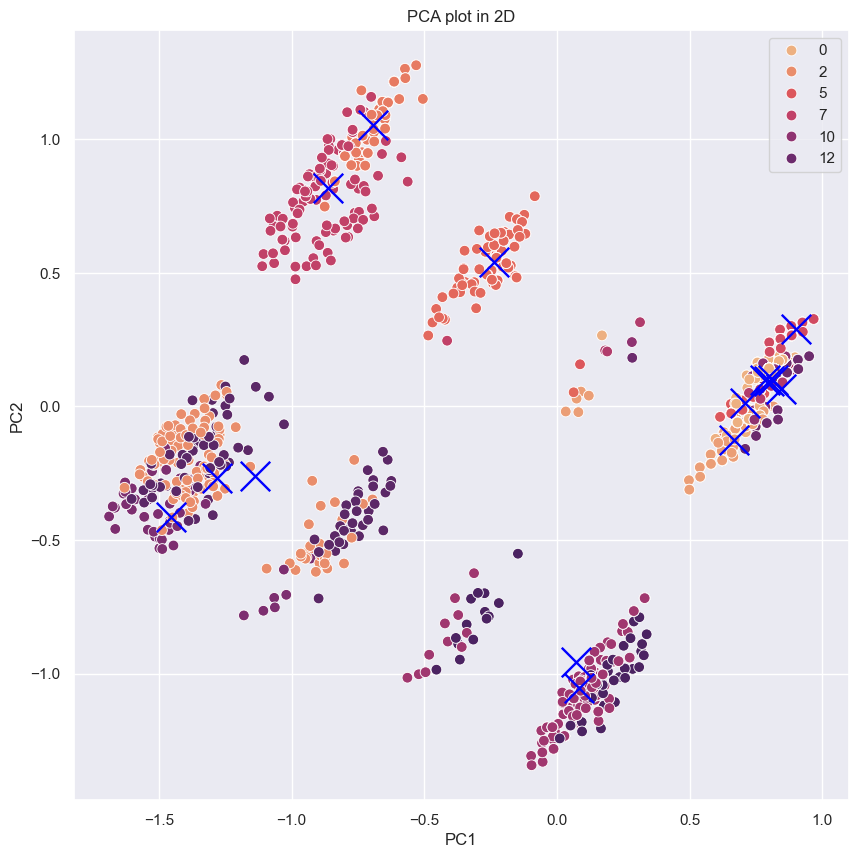

In [62]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_k,
                palette="flare",
                s=60)
sns.scatterplot(x = centroids_pca[:,0],
                y =  centroids_pca[:,1],
                marker="x",
                s=450,
                color = 'blue')
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [63]:
def PCAplot3D(x_data, y_data=None):
    components = PCA(n_components=3).fit_transform(x_data)

    fig = px.scatter_3d(
        components,
        x=0, y=1, z=2,
        color=y_data,
        size=0.1*np.ones(len(X)),
        opacity = 1,
        title='PCA plot in 3D',
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        width=900, height=900
    )
    fig.show()

In [64]:
PCAplot3D(X, pred_k)

In [66]:
# Попробовал проанализировать по какому принципу сгруппированы наблюдения в кластеры.
# Не нашел никаких закономерностей
df_with_k = df.copy()
df_with_k['cluster'] = pred_k
df_with_k.to_excel('./clusters.xlsx', index=False)

In [ ]:
# 'experience_level_cntenc', 'employee_residence_cntenc', 'company_location_cntenc', 'employment_type_CT', 	employment_type_FL	employment_type_FT	employment_type_PT	job_category_AI Specialist	job_category_Architect	job_category_BI	job_category_Data Analyst	job_category_Data Engineer	job_category_Data Scientist	job_category_Engineer	job_category_Machine Learning Engineer	job_category_Manager	job_category_Other	job_category_Research Scientist	salary_currency_AUD	salary_currency_BRL	salary_currency_CAD	salary_currency_CHF	salary_currency_CZK	salary_currency_DKK	salary_currency_EUR	salary_currency_GBP	salary_currency_HKD	salary_currency_HUF	salary_currency_ILS	salary_currency_INR	salary_currency_JPY	salary_currency_MXN	salary_currency_PLN	salary_currency_SGD	salary_currency_THB	salary_currency_TRY	salary_currency_USD	company_size_L	company_size_M	company_size_S
